In [11]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import scipy.stats as stats
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import optuna

In [12]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')

['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [13]:
# select lower missing-value ratio as features(used in random forest)
features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

In [14]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.26% missing in Age
0.14% missing in STA
0.02% missing in AR_SCORE
0.02% missing in ER_SCORE
0.02% missing in FS_SCORE
0.02% missing in CPF_SCORE
0.12% missing in IF_SCORE
0.14% missing in IS_SCORE
41.85% missing in IRN_SCORE
41.81% missing in EO_SCORE
56.92% missing in S_SCORE
4.34% missing in Overall


In [5]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024].dropna

In [6]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 80),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.7, 0.3]),
    }
    rf = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(rf, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

In [7]:
best_params_dict = {}

for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    # Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    best_params = study.best_params
    best_params_dict[target] = best_params
    best_rf = RandomForestRegressor(**best_params, random_state=2025)
    best_rf.fit(X_train, y_train)

    print(f"Best parameters for {target}: {best_params}")

    # Predict missing values
    X_test = test_data[features]
    test_data.loc[:, target] = best_rf.predict(X_test)

[I 2025-07-02 20:37:40,158] A new study created in memory with name: no-name-dc3fb882-b122-47ad-a22f-f624cf93abe9
[I 2025-07-02 20:37:42,937] Trial 0 finished with value: 23.561258406600132 and parameters: {'n_estimators': 215, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 0 with value: 23.561258406600132.
[I 2025-07-02 20:37:44,018] Trial 1 finished with value: 23.32398929985929 and parameters: {'n_estimators': 310, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 23.32398929985929.
[I 2025-07-02 20:37:45,121] Trial 2 finished with value: 23.320940625536224 and parameters: {'n_estimators': 311, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 23.320940625536224.
[I 2025-07-02 20:37:46,492] Trial 3 finished with value: 23.320017548934278 and parameters: {'n_estimators': 481, 'max_depth': 29, 'min_sam

[I 2025-07-02 20:38:15,570] Trial 33 finished with value: 23.204678847965496 and parameters: {'n_estimators': 317, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 23.18348804052772.
[I 2025-07-02 20:38:16,003] Trial 34 finished with value: 23.68064155274838 and parameters: {'n_estimators': 192, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 23.18348804052772.
[I 2025-07-02 20:38:16,864] Trial 35 finished with value: 23.184376924625525 and parameters: {'n_estimators': 285, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 23.18348804052772.
[I 2025-07-02 20:38:17,752] Trial 36 finished with value: 23.229192795147934 and parameters: {'n_estimators': 279, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 23.1834880405

[I 2025-07-02 20:38:45,173] Trial 66 finished with value: 23.24912397090952 and parameters: {'n_estimators': 262, 'max_depth': 79, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 43 with value: 23.1793923036284.
[I 2025-07-02 20:38:45,705] Trial 67 finished with value: 23.234700838198023 and parameters: {'n_estimators': 173, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 43 with value: 23.1793923036284.
[I 2025-07-02 20:38:46,490] Trial 68 finished with value: 23.305099933090663 and parameters: {'n_estimators': 227, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 23.1793923036284.
[I 2025-07-02 20:38:47,153] Trial 69 finished with value: 23.253526161070436 and parameters: {'n_estimators': 215, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 43 with value: 23.179392303628

[I 2025-07-02 20:39:15,733] Trial 99 finished with value: 23.32578892984942 and parameters: {'n_estimators': 280, 'max_depth': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 43 with value: 23.1793923036284.


Best parameters for IRN_SCORE: {'n_estimators': 406, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


D:\Users\57176\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
[I 2025-07-02 20:39:18,436] A new study created in memory with name: no-name-ad1e087a-588d-460c-ad39-b142cac792e5
[I 2025-07-02 20:39:18,913] Trial 0 finished with value: 15.9133475306474 and parameters: {'n_estimators': 192, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 15.9133475306474.
[I 2025-07-02 20:39:19,693] Trial 1 finished with value: 16.230788833426505 and parameters: {'n_estimators': 363, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with va

[I 2025-07-02 20:39:55,911] Trial 31 finished with value: 14.706716096967797 and parameters: {'n_estimators': 499, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 18 with value: 14.635299857389393.
[I 2025-07-02 20:39:57,553] Trial 32 finished with value: 14.880427534596086 and parameters: {'n_estimators': 492, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 18 with value: 14.635299857389393.
[I 2025-07-02 20:39:59,003] Trial 33 finished with value: 14.803081834524411 and parameters: {'n_estimators': 436, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 18 with value: 14.635299857389393.
[I 2025-07-02 20:40:00,447] Trial 34 finished with value: 14.882234973673556 and parameters: {'n_estimators': 470, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 14.63529985738939

[I 2025-07-02 20:40:41,157] Trial 64 finished with value: 14.576523911930073 and parameters: {'n_estimators': 391, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 45 with value: 14.570208559755754.
[I 2025-07-02 20:40:42,310] Trial 65 finished with value: 15.170123360568118 and parameters: {'n_estimators': 396, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 45 with value: 14.570208559755754.
[I 2025-07-02 20:40:43,733] Trial 66 finished with value: 14.579873967003778 and parameters: {'n_estimators': 379, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 45 with value: 14.570208559755754.
[I 2025-07-02 20:40:45,183] Trial 67 finished with value: 14.581380615752275 and parameters: {'n_estimators': 375, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 45 with value: 14.570208559755754.


[I 2025-07-02 20:41:24,247] Trial 97 finished with value: 14.879021506328101 and parameters: {'n_estimators': 426, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 92 with value: 14.560541731230368.
[I 2025-07-02 20:41:25,861] Trial 98 finished with value: 14.578611395963081 and parameters: {'n_estimators': 442, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 92 with value: 14.560541731230368.
[I 2025-07-02 20:41:27,403] Trial 99 finished with value: 14.645867871876675 and parameters: {'n_estimators': 455, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 92 with value: 14.560541731230368.


Best parameters for EO_SCORE: {'n_estimators': 371, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}


D:\Users\57176\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
[I 2025-07-02 20:41:31,363] A new study created in memory with name: no-name-86514d63-f85e-4690-acf5-fad2714534a4
[I 2025-07-02 20:41:31,862] Trial 0 finished with value: 18.570319758989115 and parameters: {'n_estimators': 155, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 18.570319758989115.
[I 2025-07-02 20:41:32,517] Trial 1 finished with value: 19.473407671750554 and parameters: {'n_estimators': 252, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with

[I 2025-07-02 20:42:00,473] Trial 31 finished with value: 18.28776594612543 and parameters: {'n_estimators': 144, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 18 with value: 18.247082467247818.
[I 2025-07-02 20:42:01,235] Trial 32 finished with value: 18.510444560819877 and parameters: {'n_estimators': 136, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 18 with value: 18.247082467247818.
[I 2025-07-02 20:42:02,487] Trial 33 finished with value: 18.24304033609886 and parameters: {'n_estimators': 214, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 33 with value: 18.24304033609886.
[I 2025-07-02 20:42:03,347] Trial 34 finished with value: 18.165004637056043 and parameters: {'n_estimators': 221, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 34 with value: 18.165004637056043.


[I 2025-07-02 20:42:34,603] Trial 64 finished with value: 18.873288641484784 and parameters: {'n_estimators': 263, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 34 with value: 18.165004637056043.
[I 2025-07-02 20:42:35,382] Trial 65 finished with value: 18.507956806881168 and parameters: {'n_estimators': 234, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 34 with value: 18.165004637056043.
[I 2025-07-02 20:42:36,403] Trial 66 finished with value: 18.175708705942544 and parameters: {'n_estimators': 261, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 18.165004637056043.
[I 2025-07-02 20:42:37,211] Trial 67 finished with value: 18.776799247718575 and parameters: {'n_estimators': 291, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 34 with value: 18.1650

[I 2025-07-02 20:42:59,070] Trial 97 finished with value: 18.499149142995197 and parameters: {'n_estimators': 141, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 95 with value: 18.142254249945633.
[I 2025-07-02 20:42:59,724] Trial 98 finished with value: 18.25085674891402 and parameters: {'n_estimators': 182, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 95 with value: 18.142254249945633.
[I 2025-07-02 20:43:00,485] Trial 99 finished with value: 18.15612953099774 and parameters: {'n_estimators': 204, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 95 with value: 18.142254249945633.


Best parameters for S_SCORE: {'n_estimators': 181, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


D:\Users\57176\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS.csv', index=False)

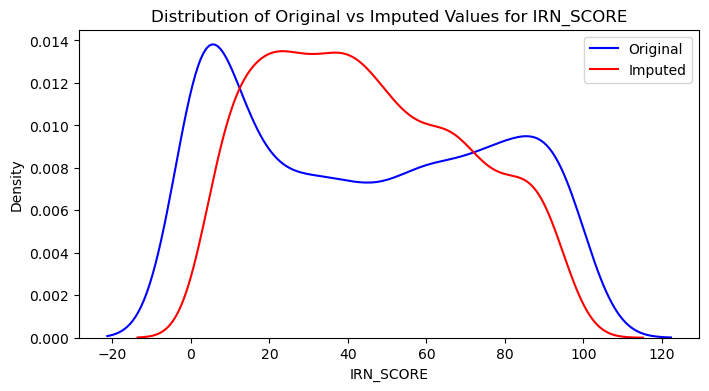

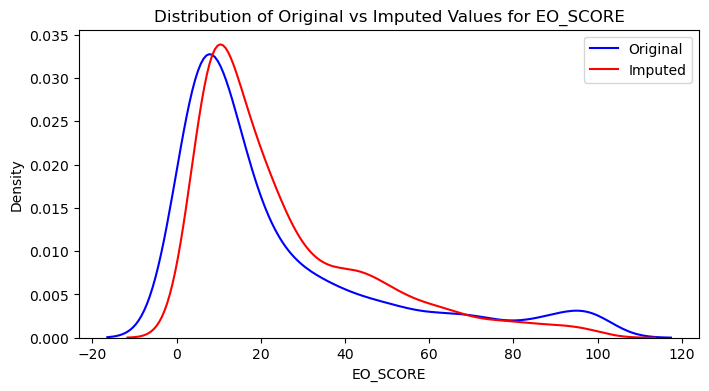

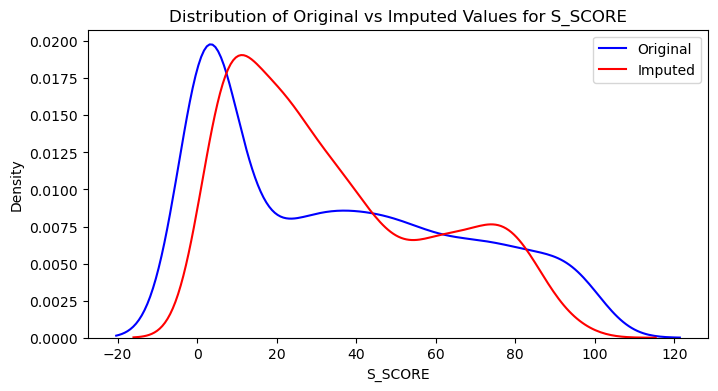

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.675904  18.617731  14.774159
1   EO_SCORE  0.672097  14.630331  10.216932
2    S_SCORE  0.742071  15.894973  12.524651


In [9]:
synthetic_data = train_data.copy()
synthetic_data = synthetic_data.dropna()

for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.4 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# Dictionary to store evaluation metrics
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Impute each target column and calculate metrics
for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]
    
    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]
    
    # Retrieve best parameters for this target
    best_params = best_params_dict[target]
    
    # Set up RandomForestRegressor with best parameters
    rf = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=2025
    )
    
    # Fit and predict
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison
    plt.figure(figsize=(8, 4))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)